<a href="https://colab.research.google.com/github/PabloParadaSouto/Automatica/blob/master/ACTOR-CRITIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
!apt install xvfb -y
!pip install pyvirtualdisplay
from pyvirtualdisplay import Display
from IPython import display

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 7,813 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archiv

KeyboardInterrupt: 

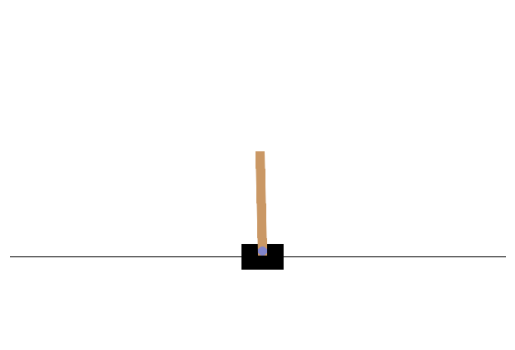

In [2]:
# Definir la red del Actor
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

# Definir la red del Crítico
class Critic(nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Definir el algoritmo Actor-Crítico
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(ActorCritic, self).__init__()
        self.actor = Actor(state_dim, action_dim, hidden_dim)
        self.critic = Critic(state_dim, hidden_dim)

    def forward(self, x):
        return self.actor(x), self.critic(x)

# Parámetros de entrenamiento
gamma = 0.99
lr = 0.01
num_episodes = 1000
hidden_dim = 128

# Inicializar el entorno
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Inicializar la red Actor-Crítico
ac_model = ActorCritic(state_dim, action_dim, hidden_dim)
optimizer = optim.Adam(ac_model.parameters(), lr=lr)

# Función para calcular el retorno descontado
def compute_discounted_rewards(rewards):
    discounted_rewards = np.zeros_like(rewards)
    R = 0
    for t in reversed(range(len(rewards))):
        R = rewards[t] + gamma * R
        discounted_rewards[t] = R
    return discounted_rewards

# Entrenamiento del modelo
d = Display()
d.start()
for episode in range(num_episodes):
    state = env.reset()
    episode_log_probs = []
    episode_rewards = []

    while True:
        state = torch.FloatTensor(state).unsqueeze(0)
        action_probs, value = ac_model(state)
        action_dist = torch.distributions.Categorical(action_probs)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        next_state, reward, done, _ = env.step(action.item())

        episode_log_probs.append(log_prob)
        episode_rewards.append(reward)

        if done:
            break
        else:
            state = next_state

        img = plt.imshow(env.render('rgb_array'))

        display.clear_output(wait=True)
        img.set_data(env.render('rgb_array'))
        plt.axis('off')
        display.display(plt.gcf())

        print("ACCION: ", action)

    # Calcular los retornos descontados
    discounted_rewards = compute_discounted_rewards(episode_rewards)

    # Calcular los valores predichos y los advantages
    #print(episode_rewards)
    #cat concatena los tensores a lo largo de la dimension 0
    #unsqueeze() agrega una dimension en la dimension especificada
    values = torch.cat([torch.tensor(r).unsqueeze(0) for r in episode_rewards]).unsqueeze(1)
    advantages = torch.tensor(discounted_rewards) - values

    # Calcular las pérdidas del Actor y del Crítico
    #stack apila tensores a lo largo de una dimension
    #detach crea una copia del tensor pero con los gradientes deshabilitados
    actor_loss = -torch.stack(episode_log_probs) * advantages.detach()
    critic_loss = advantages.pow(2).mean()

    # Calcular el loss total
    loss = actor_loss.sum() + critic_loss

    # Optimizar los parámetros del modelo
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Mostrar información sobre el episodio
    if episode % 10 == 0:
        print(f"Episode {episode}, Total Reward: {sum(episode_rewards)}")

# Cerrar el entorno
env.close()